In [1]:
import yfinance as yf
import pandas as pd

# Download NVIDA stock data from Yahoo Finance
data = yf.download('NVDA', start='2015-01-01', end='2025-10-01', interval='1d')

/var/folders/94/18sqr3292qj66m2k622fh4580000gn/T/ipykernel_18510/3920941329.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('NVDA', start='2015-01-01', end='2025-10-01', interval='1d')
[*********************100%***********************]  1 of 1 completed


In [2]:
df = pd.DataFrame(data=data.values, columns=['Close', 'High', 'Low', 'Open', 'Volume'])
df.insert(0, 'Date', data.index)
df

,Date,Close,High,Low,Open,Volume
0,2015-01-02,0.483038,0.486638,0.475360,0.483038,113680000.0
1,2015-01-05,0.474880,0.484478,0.472720,0.483038,197952000.0
2,2015-01-06,0.460482,0.476079,0.460002,0.475600,197764000.0
3,2015-01-07,0.459282,0.467921,0.457842,0.463841,321808000.0
4,2015-01-08,0.476559,0.479439,0.464321,0.464561,283780000.0
...,...,...,...,...,...,...
2697,2025-09-24,176.970001,179.779999,175.399994,179.770004,143564100.0
2698,2025-09-25,177.690002,180.259995,173.130005,174.479996,191586700.0
2699,2025-09-26,178.190002,179.770004,174.929993,178.169998,148573700.0
2700,2025-09-29,181.850006,184.000000,180.320007,180.429993,193063500.0


In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Dropout, Flatten, MaxPooling1D, Bidirectional

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

Prepare the stock data for CNN by converting dates to proper datetime format and scaling numerical features. Scaling is important because CNN models perform better when input values are normalized.


In [4]:
train_dates = pd.to_datetime(df['Date'])

train_cols = ['Close', 'High', 'Low', 'Open', 'Volume']

scaler = StandardScaler()
scaler = scaler.fit(df[train_cols]) # we need this for inverse transform later
df_scaled = scaler.transform(df[train_cols])

Prepare the input (`X_train`) and output (`y_train`) for the CNN model.

- `n_past` defines how many past days the model will use to make a prediction.
- `n_features` represents the number of days we want to predict into the future.


In [5]:
X_train = []
y_train = []
n_features = 1
n_past = 14

Reformat the data to make it suitable for the input:

- LSTM expects input in the shape **(samples, timesteps, features)**.
- For each step, we take the past `n_past` days as input (`X_train`) and predict the future `n_features` day(s) of the 'Open' price (`y_train`).


In [6]:
for i in range(n_past, len(df_scaled) - n_features + 1):
    X_train.append(df_scaled[i - n_past:i, 0: df_scaled.shape[1]])
    y_train.append(df_scaled[i + n_features - 1:i + n_features, 3])  # Predicting 'Open' price

In [7]:
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(2688, 14, 5) (2688, 1)


Define a 1D Convolutional Neural Network (CNN) autoencoder for time series prediction:

- **Conv1D layers**: Extract temporal patterns from sequences.
  - **First layer**: 64 filters, kernel size 3, `relu` activation.
  - **Second layer**: 32 filters, kernel size 3, `relu` activation.
- **Dropout layer**: Prevents overfitting by randomly ignoring 20% of neurons during training.
- **Flatten layer**: Converts 2D feature maps into 1D vector for the Dense layer.
- **Dense layer**: Outputs the predicted values of the target (e.g., 'Open' price).
- **Compile**: Using `adam` optimizer and mean squared error (`mse`) loss function.
- `model.summary()` prints the architecture and number of parameters.

It is common to combine **CNN (Conv1D) with LSTM** for time series prediction because CNN extracts local patterns and LSTM captures sequential dependencies. However, for our dataset, **a pure CNN works better**, likely because the sequences are short and the patterns are mostly local rather than long-term dependencies.


In [8]:
# Define the autoencoder model
model = Sequential()

model.add(
    Conv1D(
        filters=64,
        kernel_size=3,
        activation='relu',
        input_shape=(X_train.shape[1], X_train.shape[2])
    )
)

model.add(
    Conv1D(
        filters=32,
        kernel_size=3,
        activation='relu'
    )
)

# model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(0.2))

# model.add(Bidirectional(LSTM(32, return_sequences=False)))

model.add(Flatten())

model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 12, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,521 (29.38 KB)

 Trainable params: 7,521 (29.38 KB)

 Non-trainable params: 0 (0.00 B)

Train the LSTM model on the prepared data:

- `X_train` and `y_train` are the input and target sequences.
- `epochs=50`: The model will go through the entire dataset 50 times.
- `batch_size=32`: Number of samples processed before updating the model’s weights.
- `validation_split=0.1`: 10% of the data is used to evaluate the model during training.
- `verbose=1`: Displays the training progress for each epoch.


In [9]:
# fit the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
)

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0996 - val_loss: 0.0565
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 0.0143 - val_loss: 0.0358
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.0109 - val_loss: 0.0985
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.0095 - val_loss: 0.4437
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 0.0116 - val_loss: 0.0320
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 0.0065 - val_loss: 0.0522
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 0.0081 - val_loss: 0.1068
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 0.0051 - val_loss: 0.0489
Epoch 9/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 0.0052 - val_loss: 0.2184
Epoch 10/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 0.0059 - val_loss: 0.1355
Epoch 11/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - val_loss: 0.0547
Epoch 12/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 96

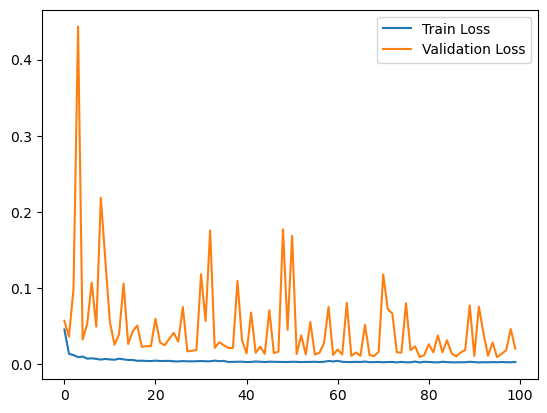

In [10]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Generate the future dates for prediction while considering only US business days:

- Import libraries to handle US federal holidays and business days.
- `n_past` specifies how many past days we look back for predictions.
- `n_days_for_prediction` is the number of future days we want to predict.
- `pd.date_range` with `CustomBusinessDay` ensures that the predicted dates skip weekends and US holidays.
- `predict_period_dates` contains the list of dates corresponding to the predictions.


In [11]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

n_past = 15
n_days_for_prediction = 14

predict_period_dates = pd.date_range(
    start=list(train_dates)[-n_past],
    periods=n_days_for_prediction,
    freq=CustomBusinessDay(calendar=USFederalHolidayCalendar())
).tolist()
predict_period_dates

[Timestamp('2025-09-10 00:00:00', freq='C'),
 Timestamp('2025-09-11 00:00:00', freq='C'),
 Timestamp('2025-09-12 00:00:00', freq='C'),
 Timestamp('2025-09-15 00:00:00', freq='C'),
 Timestamp('2025-09-16 00:00:00', freq='C'),
 Timestamp('2025-09-17 00:00:00', freq='C'),
 Timestamp('2025-09-18 00:00:00', freq='C'),
 Timestamp('2025-09-19 00:00:00', freq='C'),
 Timestamp('2025-09-22 00:00:00', freq='C'),
 Timestamp('2025-09-23 00:00:00', freq='C'),
 Timestamp('2025-09-24 00:00:00', freq='C'),
 Timestamp('2025-09-25 00:00:00', freq='C'),
 Timestamp('2025-09-26 00:00:00', freq='C'),
 Timestamp('2025-09-29 00:00:00', freq='C')]

In [12]:
# Make predictions
prediction = model.predict(X_train[-n_days_for_prediction:])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Rescale the predictions back to the original stock price range:

- The scaler was fitted on **5 features**, so inverse transformation expects the same number of columns.
- `np.repeat` duplicates the predictions across 5 columns temporarily.
- `scaler.inverse_transform` converts the normalized values back to the original scale.
- We only keep the first column (the 'Open' price) as our final predicted values (`y_pred_future`).


In [13]:
prediction_copies = np.repeat(prediction, df_scaled.shape[1], axis=1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:, 0]
y_pred_future

array([168.2563 , 171.18466, 170.73285, 170.8465 , 171.6902 , 169.47621,
       169.19556, 170.14613, 171.01357, 171.644  , 170.32791, 169.4154 ,
       171.51665, 174.70787], dtype=float32)

In [14]:
df_forecast = pd.DataFrame({
    'Date': pd.to_datetime(predict_period_dates),
    'Predicted_Open': y_pred_future
})
df_forecast

,Date,Predicted_Open
0,2025-09-10,168.256302
1,2025-09-11,171.184662
2,2025-09-12,170.732849
3,2025-09-15,170.846497
4,2025-09-16,171.690201
5,2025-09-17,169.476212
6,2025-09-18,169.195557
7,2025-09-19,170.146133
8,2025-09-22,171.013565
9,2025-09-23,171.643997


In [15]:
# Extracting original 'Open' prices for the forecasted dates for comparison
df_original = df.loc[(df['Date'] >= '2025-09-10') & (df['Date'] <= '2025-09-29'), ['Date', 'Open'] ]

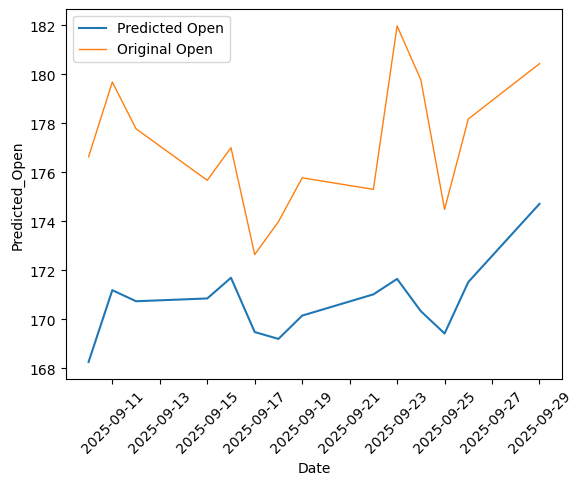

In [16]:
sns.lineplot(data=df_forecast, x='Date', y='Predicted_Open', label='Predicted Open')
sns.lineplot(data=df_original, x='Date', y='Open', linewidth=1, label='Original Open')
plt.xticks(rotation=45)
plt.show()